# Project 2: A minimal model training experiment

**Goal**:

- Create a [PyTorch LightningModule](https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html) named `ImageClassifier` that holds a convolutional network with ResNet18 backbone.
- Learn to adapt the dataset class to be compatible with the model.
- Understand a minimal set of components of a model training pipeline: loss, optimizer, metrics, training loop.
- Assemble the components to train a model using the dataset class and the dataloader created in the previous object.
- Learn how to visualize model predictions.
- Understand the concept of fine-tuning and the benefits of starting from a pre-trained model. (may move to the next project)
- Understand the benefits and options of a dataloader. (may move to the next project)

**Acceptance Criteria**:

- Implement a test that checks a simple ImageClassifier can be predict on an image that has the correct shape.
- The `ImageClassifier` can be trained on the CIFAR10 dataset, showing decreasing loss and accuracy for several epochs.

**Resources**:

- If you want to use docker to run code in this notebook, `pytorch/pytorch:1.12.0-cuda11.3-cudnn8-runtime` is a good choice.

## Step 1: Create a model using `LightningModule`

`LightningModule` is a convenient and structured way to implement a PyTorch model, as well as its training and validation behaviors. For more information, please refer to the [documentation](https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html) for `LightningModule`.

### Installation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Install the dependencies:
!pip install torch torchvision pytorch-lightning==1.6.4 torchmetrics mlflow
# If the above installation fails, try:
# !pip install torch==1.12.0 torchvision==0.13.0 pytorch-lightning==1.6.4 torchmetrics mlflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 585 kB 5.0 MB/s 
     |████████████████████████████████| 419 kB 51.5 MB/s 
     |████████████████████████████████| 17.0 MB 151 kB/s 
     |████████████████████████████████| 81 kB 12.0 MB/s 
     |████████████████████████████████| 209 kB 39.6 MB/s 
     |████████████████████████████████| 146 kB 51.4 MB/s 
     |████████████████████████████████| 79 kB 5.2 MB/s 
     |████████████████████████████████| 181 kB 59.5 MB/s 
     |████████████████████████████████| 78 kB 8.9 MB/s 
     |████████████████████████████████| 54 kB 3.4 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 59 kB 6.2 MB/s 
  Created wheel for databricks-cli: filename=databricks_cli-0.17.2-py3-none-any.whl size=143915 sha256=604bb70ceaa51671380134fed9a1b6325928d4d912d19322d713514681571f31
  Stored in directory: /root/.cache/pip/wheels/e4

### A simple image classifier module

In [3]:
import pytorch_lightning as pl
from torchvision.models import resnet18

class ImageClassifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.net = resnet18(num_classes=10, weights=None)
    
    def forward(self, x):
        return self.net(x)

In [4]:
model = ImageClassifier()

### Testing the forward path of the model

As a trainable function, the model is callable. The model's forward path (as defined in `forward()`) is the normal execution of the function. We can test this by passing an image to the model.

In [5]:
assert callable(model), "The model is not a callable object."
print("Model is callable.")

Model is callable.


#### What is a valid input?

To test the forward path of the model, we need to pass a valid input. The input should be a tensor of shape `(b, 3, 32, 32)` where `b` is the batch size (an integer).

**Your Task**: Fix the code below to pass the test.

**Tips:** `torch.from_numpy()` can be used to convert a numpy array to a tensor.


In [6]:
import numpy as np
import torch

# TODO: The test is broken. Please fix it.
def test_model_can_predict_on_a_random_image():
    # input_image = np.ones(shape=(3, 224, 224), dtype=np.float32)
    input_image = torch.from_numpy(np.ones(shape=(1, 3, 224, 224), dtype=np.float32))
    output = model(input_image)  # run the model on the input image
    assert output.shape == (1, 10)  # is the output shape correct?


test_model_can_predict_on_a_random_image()
print("Test passed")

Test passed


## Step 2: Prepare the dataset and data loader

You have two choices here and either way would work.

1. Use the `CIFAR10` dataset class provided by `torchvision`. This is easier.
   ```
   from torchvision.datasets import CIFAR10

   cifar10_train = CIFAR10(train=True, download=True, root="./cifar10")
   cifar10_val = CIFAR10(train=False, download=True, root="./cifar10")
   ```
2. Reuse the `CustomDataset` from the previous object.

In [7]:
# TODO: import `CIFAR10` or copy over the code from the previous project.
from torchvision.datasets import CIFAR10
from torchvision import transforms


cifar10_train = CIFAR10(train=True, download=True, root="./cifar10", transform=transforms.ToTensor())
cifar10_val = CIFAR10(train=False, download=True, root="./cifar10", transform=transforms.ToTensor())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified


## Step 3: Training the model

#### Loss

A loss is a function that takes the model's output (also called predictions) and the ground truth (also called "targets") as input and returns a scalar value. The loss is used as the feedback mechantism to optimize the model.

For classification, the loss is typically the cross-entropy. Use `torch.nn.functional.cross_entropy` when the model output are logits or `torch.nn.functional.nll_loss` when the outputs are probabilities (a.k.a. softmax). Loss functions can have requirements on the type (`dtype`) of input. `cross_entropy`, for example, expects targets to be "Long" or `np.int64`.

**Your Task**: The following code almost works but there is a bug related to data type. Please fix it.

In [8]:
from torch.nn import functional as F

# To simplify the code, assume there are 3 image classes.
y_pred = torch.from_numpy(np.array([[0, 0, 5]], dtype=np.float32))
# y_true = torch.from_numpy(np.array([1], dtype=np.float32))
y_true = torch.from_numpy(np.array([1], dtype=np.int64))
print(F.cross_entropy(y_pred, y_true))

tensor(5.0134)


**Your Task**: Can you make the loss lower? Try changing `y_pred` in the next cell.

In [9]:
# TODO: change y_pred to make the loss lower.
# y_pred = torch.from_numpy(np.array([[0, 0, 5]], dtype=np.float32))
y_pred = torch.from_numpy(np.array([[0, 5, 0]], dtype=np.float32))
y_true = torch.from_numpy(np.array([1], dtype=int))
print(F.cross_entropy(y_pred, y_true))

tensor(0.0134)


#### Optimizer

The gradient over model parameters (a.k.a. model weights) is computed of the loss function, and informs how the model parameters should be updated. The specifics of how the model is updated is handled by an optimizer.

An optimizer can be created by passing the model parameters (`model.parameters()`) to the optimizer constructor, as well as learning rate, momentum, and other hyper-parameters. Below is a minimal example of using an optimizer.

```python
for input, target in dataset:
    optimizer.zero_grad()
    output = model(input)
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()
```

When using `LightningModule`, this is taken care of by `LightniningModule` under the hood so you don't have to write the boilerplate code as below (pseudo-code):

```
# put model in train mode and enable gradient calculation
model.train()
torch.set_grad_enabled(True)

outs = []
for batch_idx, batch in enumerate(train_dataloader):
    loss = training_step(batch, batch_idx)
    outs.append(loss.detach())

    # clear gradients
    optimizer.zero_grad()

    # backward
    loss.backward()

    # update parameters
    optimizer.step()
```

For more details, please refer to [the documentation for PyTorch optimizers](https://pytorch.org/docs/stable/optim.html) and [the documentation for `LightningModule`](https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html).

#### Training Step

We can start specifying the training behavior to the model by adding the `training_step` method in the `ImageClassifier` class.

In [10]:
class ImageClassifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.net = resnet18(num_classes=10, weights=None)
        self.automatic_optimization = False  # 
    
    def forward(self, x):
        return self.net(x)
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)
    
    def loss(self, y_hat, y):
        return F.cross_entropy(y_hat, y)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        
        return {"loss": loss}

**Your task**: Implement the following unit test. Use the data loader to get a batch of data.
Then, call the `training_step` and assert that the return value is a dictionary that looks
like this: `{'loss': 0.5}`. 

In [11]:
from torch.utils.data import DataLoader


def test_training_step_works():
    # TODO: Use the data loader to get a batch of data.
    #    Then, call the `training_step` and assert that the return value is a dictionary that looks
    #    like this: {'loss': 0.5}.
    # ...
    model = ImageClassifier()
    dataloader = DataLoader(cifar10_train, batch_size=16)
    batch = next(iter(dataloader))
    training_step_output = model.training_step(batch, 0)
    print(training_step_output)
    assert isinstance(training_step_output, dict), f"Got type: {type(training_step_output)}"
    assert "loss" in training_step_output


test_training_step_works()

{'loss': tensor(2.6848, grad_fn=<NllLossBackward0>)}


### Metrics

A metric is a function that takes the model's output and the ground truth as input and returns a scalar value. The metric is used to evaluate the model's performance. It is mainly used to monitor the training progress and does not directly influence the model's training behavior. However, it can influence model selection and early stopping.

For classification, the metric is typically the accuracy. We will use `torchmetrics.Accuracy` in this project.

In [12]:
from torchmetrics import Accuracy

# Again, for simplicity, assume there are only 3 imge classes.
y_pred = torch.from_numpy(np.array([[0, 0, 5], [2, -1, 1]], dtype=np.float32))
# The following line is optional and shouldn't change the result.
# y_pred = F.softmax(y_pred, dim=1)
y_true = torch.from_numpy(np.array([1, 0], dtype=int))
acc = Accuracy(num_classes=3)
acc.update(y_pred, y_true)
print("Accuracy:", acc.compute())

Accuracy: tensor(0.5000)


### Training loop

A training loop manages the training process that iteratively passes batches of training examples to the model and running the training step. 

The training steps are organized into "epochs", where an epoch can be a single pass through the entire training dataset, or it can be simply a predefined number of training steps. At the end of an epoch, the model is used predict on the validation dataset and calculate accuracy metrics.

To do this, we need to add `validation_step` and `validation_epoch_end` methods and accuracy metrics to the model.

In [13]:
from torchmetrics import Accuracy


class ImageClassifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.net = resnet18(num_classes=10, weights=None)
        self.val_accuracy = Accuracy(num_classes=10)
    
    def forward(self, x):
        return self.net(x)
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)
    
    def loss(self, y_hat, y):
        return F.cross_entropy(y_hat, y)
    
    def training_step(self, batch, batch_idx=None):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)

        # Note: The return value can be None, a loss tensor, or a dictionary with a "loss" key.
        return {"loss": loss}
    
    def validation_step(self, batch, batch_idx=None):
        x, y = batch
        y_hat = self(x)
        self.val_accuracy.update(preds=y_hat, target=y)
        val_loss = self.loss(y_hat, y)
        return {"loss": val_loss}

### Start model training

**Your Task**: In the next cells, fill out the details in the training loop implementation. The training loop can be described in pseudo code:

```python
for epoch in epochs:
    for train_step in train_steps_per_epoch:
        # TODO: loop over the training dataset and run training steps
        pass
    
    # TODO: loop over the validation dataset and run validation steps.
```

In [14]:
from tqdm import tqdm

epochs = 6
train_steps_per_epoch = 100
val_steps_per_epoch = 10

train_dataloader = DataLoader(cifar10_train, batch_size=16)
val_dataloader = DataLoader(cifar10_val, batch_size=16)


def get_infinite_data_iterator(dataloader):
  while True:
    for batch in iter(dataloader):
      yield batch


#
# The training loop:
#
def training_loop(model, train_dataloader, val_dataloader):
    train_data_iterator = get_infinite_data_iterator(train_dataloader)
    optimizer = model.configure_optimizers()
    for epoch in range(epochs):
        train_losses = []
        train_steps = tqdm(list(range(train_steps_per_epoch)))
        for train_step in train_steps:
            # TODO: loop over the training dataset and run training steps
            batch = next(train_data_iterator)
            train_step_loss = model.training_step(batch)
            # Back-prop and update model's weights.
            optimizer.zero_grad()
            train_step_loss["loss"].backward()
            optimizer.step()
            train_losses.append(train_step_loss["loss"].item())
            avg_train_loss = np.mean(train_losses)
            train_steps.set_postfix({"loss": avg_train_loss})
        print(f"epoch {epoch}: train loss = {avg_train_loss:.5f}")
        
        # TODO: loop over the validation dataset and run validation steps.
        # Just using the first few examples from the validation set.
        val_data_iterator = iter(val_dataloader)
        val_losses = []
        for val_step in range(val_steps_per_epoch):
          batch = next(val_data_iterator)
          val_step_loss = model.validation_step(batch, val_step)
          val_losses.append(val_step_loss["loss"].item())
        avg_val_loss = np.mean(val_losses)
        val_accuracy = model.val_accuracy.compute()
        print(f"epoch {epoch}: val loss = {avg_val_loss:.5f}, accuracy = {val_accuracy:.3f}")


model_v1 = ImageClassifier()
training_loop(model_v1, train_dataloader, val_dataloader)

100%|██████████| 100/100 [00:27<00:00,  3.59it/s, loss=2.1]


epoch 0: train loss = 2.10296
epoch 0: val loss = 1.92865, accuracy = 0.306


100%|██████████| 100/100 [00:27<00:00,  3.59it/s, loss=1.9]


epoch 1: train loss = 1.89501
epoch 1: val loss = 1.94615, accuracy = 0.287


100%|██████████| 100/100 [00:26<00:00,  3.71it/s, loss=1.83]


epoch 2: train loss = 1.82609
epoch 2: val loss = 1.80923, accuracy = 0.321


100%|██████████| 100/100 [00:27<00:00,  3.70it/s, loss=1.78]


epoch 3: train loss = 1.77877
epoch 3: val loss = 1.79830, accuracy = 0.328


100%|██████████| 100/100 [00:26<00:00,  3.78it/s, loss=1.74]


epoch 4: train loss = 1.73864
epoch 4: val loss = 1.70283, accuracy = 0.339


100%|██████████| 100/100 [00:27<00:00,  3.70it/s, loss=1.7]


epoch 5: train loss = 1.69750
epoch 5: val loss = 1.62756, accuracy = 0.351


## Step 4: Visualize model predictions

Having loss going down and accuracy going up is nice. But to have the peace of mind that the model is working and is indeed better, it is helpful to visualize the model's predictions.

**Your Task**: Complete the following cells to visualize the model's predictions.

First, visualize predictions from a randomly initialized model:

In [15]:
# TODO: call the un-trained model to predict on a few images from the validation set.
#   Use the skill learned in project 1 to display a batch of images.

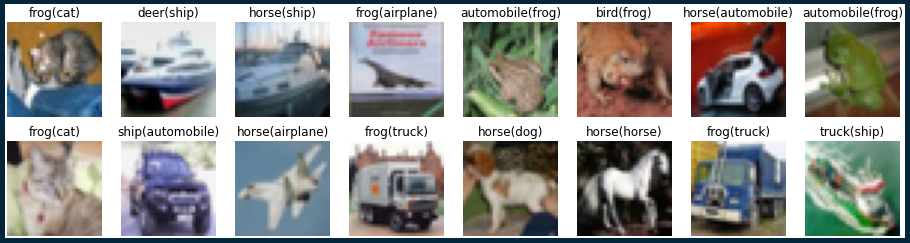

In [16]:
from matplotlib import pyplot as plt


def show_images(images, labels: list = None, ncols: int = 8):
    nrows = (len(images) + ncols - 1) // ncols
    fig = plt.figure(figsize=(2 * ncols, 2 * nrows), linewidth=10, edgecolor="#04253a")
    for i in range(len(images)):
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(images[i])
        if labels is not None:
          plt.title(labels[i])
        plt.axis('off')
    # fig.set_facecolor("#e1ddbf")
    return fig


def predict_and_show(model, output_path=None):
    batch = next(iter(val_dataloader))
    images, labels = batch
    softmax = model(images)
    softmax = softmax.detach().numpy()
    predicted_labels = np.argmax(softmax, axis=-1)
    CLASSES = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
              "horse", "ship", "truck"]
    predicted_label_texts = [f"{CLASSES[pred]}({CLASSES[correct]})" for pred, correct in zip(predicted_labels, labels)]
    fig = show_images(images.numpy().transpose(0, 2, 3, 1), predicted_label_texts)
    if output_path:
        fig.savefig(output_path)


randomly_initialized_model = ImageClassifier()
predict_and_show(randomly_initialized_model, "random_model.png")

Next, take the trained model:

In [17]:
# TODO: call the trained model to predict on a few images from the validation set.
#   Do predictions look better than the untrained, randomly initialized model?

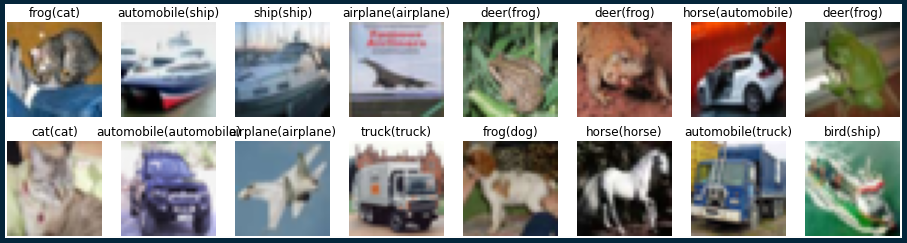

In [18]:
predict_and_show(model_v1)

## Step 5: Using the `Trainer` provided by Pytorch-Lightning

For commonly used computer vision models, it is often enough to the `Trainer` provided by Pytorch-Lightning to handle the training loop. This way, you can run model training with just a couple lines of code.

### Logging

## Hooks

In [19]:
from pytorch_lightning.callbacks import Callback

class ImageClassifierCallback(Callback):

    def __init__(self, save_prediction_examples=False, *args, **kwargs):
      super().__init__(*args, **kwargs)
      self.current_epoch = 0
      self.save_prediction_examples = save_prediction_examples
    
    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        super().on_train_batch_end(trainer, pl_module, outputs, batch, batch_idx)
        loss = outputs["loss"]
        self.log(name="loss", value=loss.item(), on_step=True)
    
    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx):
        super().on_validation_batch_end(trainer, pl_module, outputs, batch, batch_idx, dataloader_idx)
        loss = outputs["loss"]
        self.log(name="loss", value=loss.item(), on_step=True)
        self.log(name="acc", value=pl_module.val_accuracy.compute(), on_step=True)
        return {"loss": loss}
      
    def _log_prediction_examples(self, trainer, pl_module):
        figure_path = f"{self.current_epoch:05d}.png"
        # Warning: `predict_and_show` comes with val_dataloader. It works in this
        #   notebook. If you want to use it elsewhere, make sure to pass in your
        #   own dataloader.
        predict_and_show(pl_module, output_path=figure_path)
        experiment_tracker = trainer.logger.experiment
        experiment_tracker.log_artifact(run_id=trainer.logger.run_id, local_path=figure_path)
    
    def on_validation_epoch_end(self, trainer, pl_module, *args, **kwargs):
        super().on_validation_epoch_end(trainer, pl_module, *args, **kwargs)
        avg_acc = pl_module.val_accuracy.compute()
        self.log('val_acc', avg_acc, prog_bar=True)
        print("val_accuracy:", avg_acc)
        if self.save_prediction_examples:
            self._log_prediction_examples(trainer, pl_module)
        self.current_epoch += 1

In [20]:
from pytorch_lightning import Trainer, seed_everything

# Optional: freeze the random seed.
seed_everything(42, workers=True)
trainer = Trainer(deterministic=True, limit_train_batches=100, limit_val_batches=10, max_epochs=5, callbacks=[ImageClassifierCallback()])
# Feel free to use `accelerator="gpu"` if GPU is available.
model_v2 = ImageClassifier()
trainer.fit(model_v2, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1817: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type     | Params
------------------------------------------
0 | net          | ResNet   | 11.2 M
1 | val_accuracy | Accuracy | 0     
------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

val_accuracy: tensor(0.0625)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

val_accuracy: tensor(0.2552)


Validation: 0it [00:00, ?it/s]

val_accuracy: tensor(0.2955)


Validation: 0it [00:00, ?it/s]

val_accuracy: tensor(0.3066)


Validation: 0it [00:00, ?it/s]

val_accuracy: tensor(0.3006)


Validation: 0it [00:00, ?it/s]

val_accuracy: tensor(0.3065)


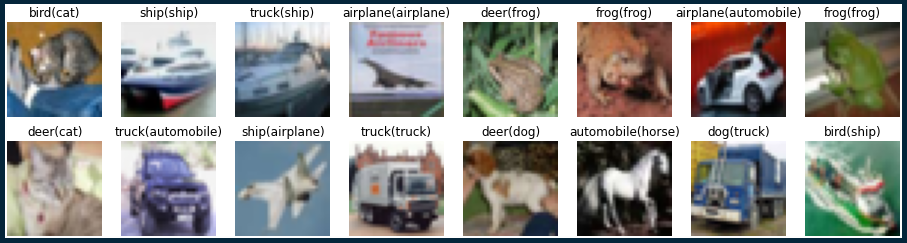

In [21]:
predict_and_show(model_v2)

## Step 6 (optional): Track the model's progress using an experiment tracking tool

Tracking model's quality during training is made easy by great experiment tracking tools like `mlflow`. With a small change to your training code, we will walk through how to use it to track your model's progress in learning.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1817: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type     | Params
------------------------------------------
0 | net          | ResNet   | 11.2 M
1 | val_accuracy | Accuracy | 0     
------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

val_accuracy: tensor(0.0938)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

val_accuracy: tensor(0.2865)


Validation: 0it [00:00, ?it/s]

val_accuracy: tensor(0.2955)


Validation: 0it [00:00, ?it/s]

val_accuracy: tensor(0.3008)


Validation: 0it [00:00, ?it/s]

val_accuracy: tensor(0.3125)


Validation: 0it [00:00, ?it/s]

val_accuracy: tensor(0.3209)


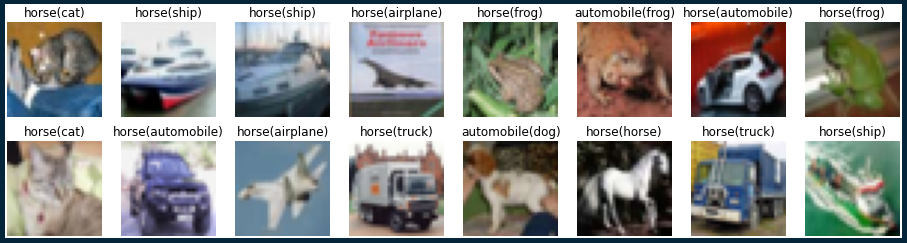

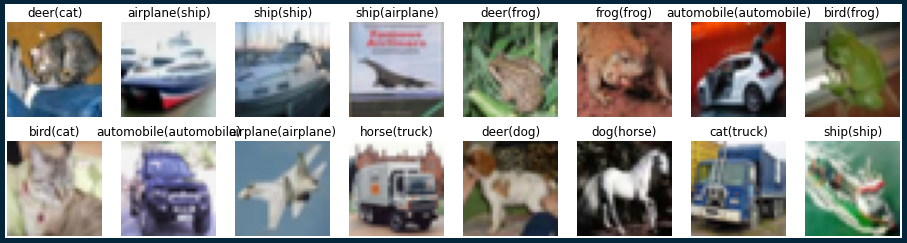

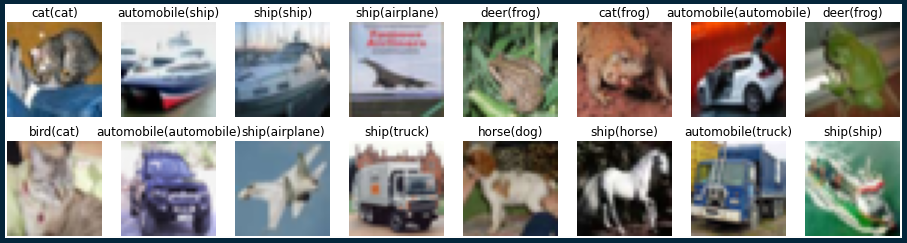

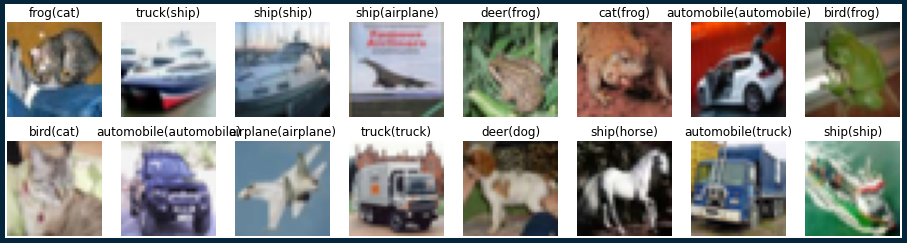

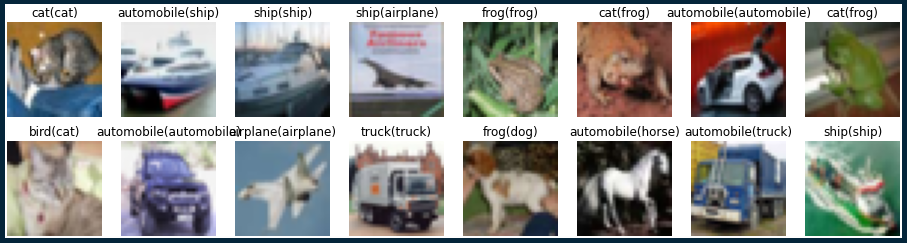

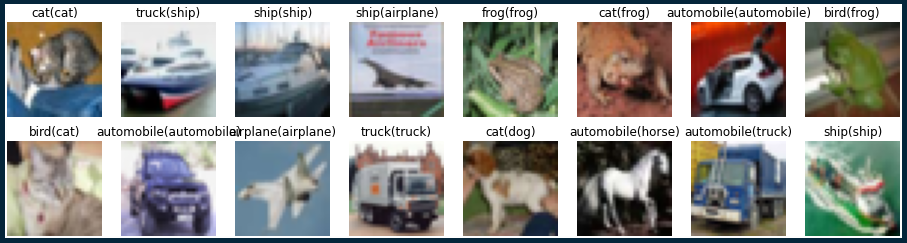

In [22]:
from pytorch_lightning.loggers import MLFlowLogger

trainer = Trainer(
    limit_train_batches=100,
    limit_val_batches=10,
    max_epochs=5,
    logger=MLFlowLogger(experiment_name="image classifier", tracking_uri="./mlruns"),
    callbacks=[ImageClassifierCallback(save_prediction_examples=True)]
)
# Feel free to use `accelerator="gpu"` if GPU is available.

model_v3 = ImageClassifier()
trainer.fit(model_v3, train_dataloader, val_dataloader)

The tracking information is already saved by MLFlow. If you are running this on a local computer, you can type: 

```mlflow ui```

and view the MLFlow GUI in your browser.

If you are running this in colab or on a remote server, you can use the following code to visualize metrics and artifacts within this notebook.

In [23]:
import mlflow

client = mlflow.client.MlflowClient(tracking_uri="./mlruns")
exp = client.get_experiment_by_name("image classifier")
runs = client.list_run_infos(exp.experiment_id, order_by=["tag.start_time DESC"])
latest_run = runs[0]
latest_run

<RunInfo: artifact_uri='./mlruns/1/8dda7716d8324c25afe9881073256aa6/artifacts', end_time=1660943827410, experiment_id='1', lifecycle_stage='active', run_id='8dda7716d8324c25afe9881073256aa6', run_uuid='8dda7716d8324c25afe9881073256aa6', start_time=1660943684990, status='FINISHED', user_id='root'>

In [24]:
val_acc_history = client.get_metric_history(latest_run.run_id, key="val_acc")
val_acc_history

[<Metric: key='val_acc', step=99, timestamp=1660943714450, value=0.2864583432674408>,
 <Metric: key='val_acc', step=199, timestamp=1660943742018, value=0.2954545319080353>,
 <Metric: key='val_acc', step=299, timestamp=1660943770227, value=0.30078125>,
 <Metric: key='val_acc', step=399, timestamp=1660943798054, value=0.3125>,
 <Metric: key='val_acc', step=499, timestamp=1660943826942, value=0.3209134638309479>]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


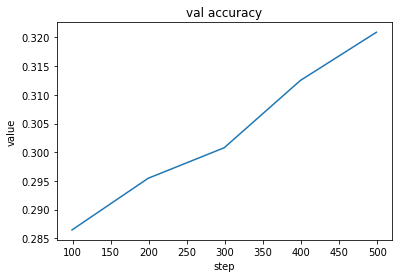

In [25]:
import seaborn

steps = [m.step for m in val_acc_history]
val_acc = [m.value for m in val_acc_history]

fig = seaborn.lineplot(steps, val_acc).set(title="val accuracy", xlabel="step", ylabel="value")

The image artifacts that contain prediction examples can also be retrieved and downloaded. Here we don't visualize them again because the images probably already show up in the cell above.

In [26]:
client.list_artifacts(run_id=latest_run.run_id)

[<FileInfo: file_size=234054, is_dir=False, path='00000.png'>,
 <FileInfo: file_size=237458, is_dir=False, path='00001.png'>,
 <FileInfo: file_size=237111, is_dir=False, path='00002.png'>,
 <FileInfo: file_size=237357, is_dir=False, path='00003.png'>,
 <FileInfo: file_size=236952, is_dir=False, path='00004.png'>,
 <FileInfo: file_size=237553, is_dir=False, path='00005.png'>]